
# CIFAR-10 Image Classification with CNNs
This notebook completes all tasks in the **Deep Learning Assignment**:
1. Data Exploration & Preparation
2. Build & Train a CNN
3. Evaluate the Model
4. Experimentation with Optimizers

> Dataset: **CIFAR-10** (32×32 color images, 10 classes)


In [1]:

# === Imports & Setup ===
import os, random, numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Metrics & evaluation
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)


TF version: 2.20.0


In [2]:

# === Helper utilities ===

# CIFAR-10 class names (index -> label)
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def show_samples(images, labels, n=5, title="Sample images"):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        label_idx = int(labels[i])
        ax.set_title(CLASS_NAMES[label_idx])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # Plot loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



## Task 1 — Data Exploration and Preparation
- Load CIFAR-10
- Show 5 sample images with labels
- Print shapes and unique label counts
- Normalize to [0, 1]
- Split 80% train / 20% test


Original training data: (50000, 32, 32, 3) (50000, 1)
Original test data: (10000, 32, 32, 3) (10000, 1)
Training data shape: (48000, 32, 32, 3) (48000,)
Test data shape: (12000, 32, 32, 3) (12000,)
Unique labels: 10 [0 1 2 3 4 5 6 7 8 9]


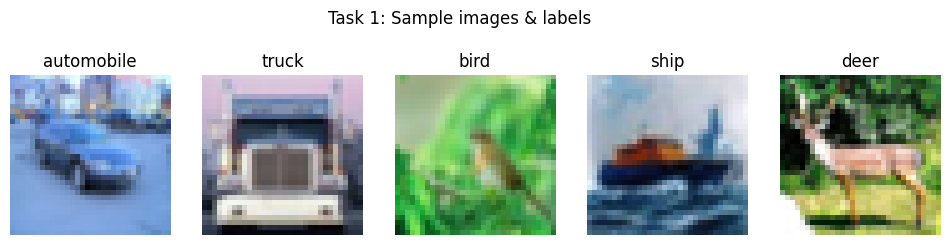

In [3]:

# === Load CIFAR-10 ===
from tensorflow.keras.datasets import cifar10
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = cifar10.load_data()

print("Original training data:", x_train_orig.shape, y_train_orig.shape)
print("Original test data:", x_test_orig.shape, y_test_orig.shape)

# Combine and re-split to exactly 80/20
X_all = np.concatenate([x_train_orig, x_test_orig], axis=0)
y_all = np.concatenate([y_train_orig, y_test_orig], axis=0).reshape(-1)

num_samples = X_all.shape[0]
idx = np.arange(num_samples)
np.random.shuffle(idx)

train_size = int(0.8 * num_samples)
train_idx, test_idx = idx[:train_size], idx[train_size:]

x_train, y_train = X_all[train_idx], y_all[train_idx]
x_test, y_test = X_all[test_idx], y_all[test_idx]

print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)
print("Unique labels:", len(np.unique(y_all)), np.unique(y_all))

# Show 5 sample images
show_samples(x_train, y_train, n=5, title="Task 1: Sample images & labels")

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0



## Task 2 — Build and Train a CNN Model
Architecture example (repeat 2–3 times): Conv2D → ReLU → MaxPooling → Dropout  
Then: Flatten → Dense → Output (Softmax)  
Train 10–20 epochs and plot training/validation curves.


In [4]:

# === Define CNN model ===
def build_cnn(input_shape=(32,32,3), num_classes=10, dropout_rate=0.25):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

base_model = build_cnn()
base_model.summary()


C:\Users\ermoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.3976 - loss: 1.6265 - val_accuracy: 0.5397 - val_loss: 1.2930
Epoch 2/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5448 - loss: 1.2618 - val_accuracy: 0.6005 - val_loss: 1.1191
Epoch 3/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6046 - loss: 1.1105 - val_accuracy: 0.6660 - val_loss: 0.9446
Epoch 4/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6400 - loss: 1.0124 - val_accuracy: 0.6837 - val_loss: 0.8988
Epoch 5/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6686 - loss: 0.9386 - val_accuracy: 0.6999 - val_loss: 0.8598
Epoch 6/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.6866 - loss: 0.8808 - val_accuracy: 0.7158 - val_loss: 0.8067
Epoch 7/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.7032 - loss: 0.8419 - val_accuracy: 0.7317 - val_loss: 0.7555
Epoch 8/12
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.7141 - loss: 0.8041 - 

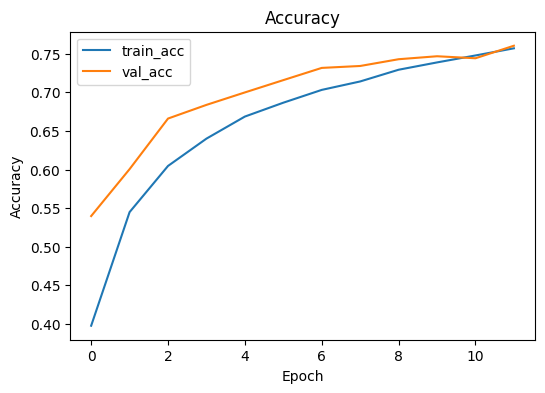

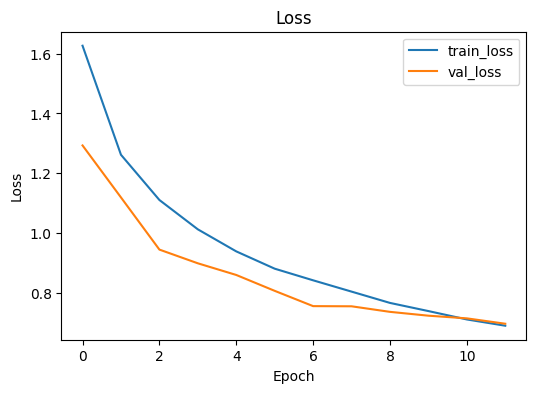

In [5]:

# === Compile & Train ===
EPOCHS = 12  # adjust 10–20 as required
BATCH_SIZE = 64

base_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history = base_model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)

# Plot training curves
plot_training_history(history)



**Comment on Overfitting/Underfitting:**  
- If training accuracy is much higher than validation and validation loss rises → **overfitting**.  
- If both accuracies are low and rising slowly → **underfitting** (consider more capacity/epochs).  



## Task 3 — Evaluate the Model
- Test accuracy
- Confusion matrix & classification report
- Examples of correctly and incorrectly classified images


Test accuracy: 0.7528, Test loss: 0.7086

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.79      0.78      1177
  automobile       0.84      0.90      0.87      1167
        bird       0.71      0.62      0.66      1213
         cat       0.65      0.44      0.52      1158
        deer       0.67      0.75      0.70      1219
         dog       0.65      0.67      0.66      1216
        frog       0.74      0.85      0.79      1246
       horse       0.75      0.83      0.79      1259
        ship       0.88      0.87      0.87      1197
       truck       0.87      0.80      0.83      1148

    accuracy                           0.75     12000
   macro avg       0.75      0.75      0.75     12000
weighted avg       0.75      0.75      0.75     12000



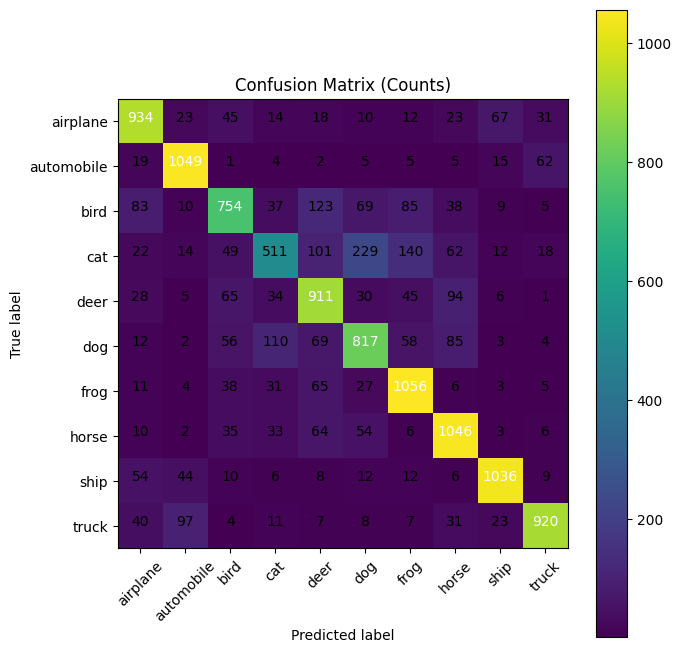

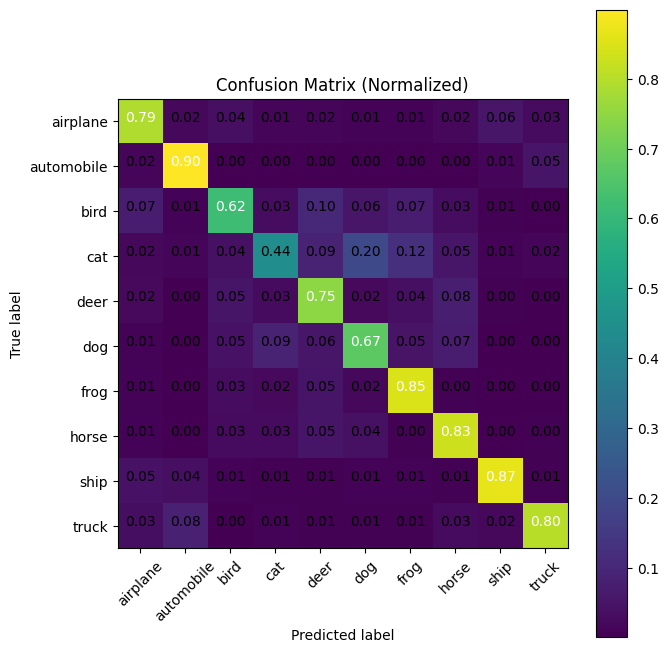

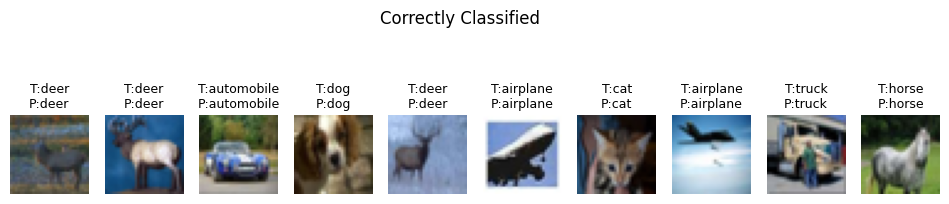

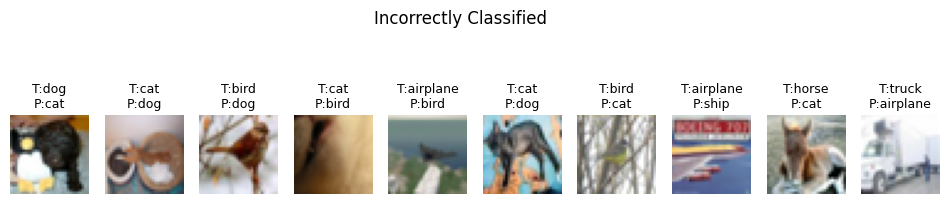

In [6]:

# === Evaluate on test set ===
test_loss, test_acc = base_model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Predictions
y_prob = base_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, CLASS_NAMES, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, CLASS_NAMES, normalize=True, title="Confusion Matrix (Normalized)")

# Show examples of correct & incorrect predictions
def show_examples(images, true_labels, pred_labels, correct=True, k=10, title="Examples"):
    mask = (true_labels == pred_labels) if correct else (true_labels != pred_labels)
    idxs = np.where(mask)[0][:k]
    if len(idxs) == 0:
        print("No examples to show.")
        return
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(1, min(k, len(idxs)), i+1)
        plt.imshow(images[idx])
        ax.set_title(f"T:{CLASS_NAMES[int(true_labels[idx])]}\nP:{CLASS_NAMES[int(pred_labels[idx])]}",
                     fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_examples(x_test, y_test, y_pred, correct=True, k=10, title="Correctly Classified")
show_examples(x_test, y_test, y_pred, correct=False, k=10, title="Incorrectly Classified")



## Task 4 — Experimentation with Model Improvements
Try different optimizers (e.g., **SGD**, **RMSprop**) and compare against **Adam**.


In [7]:

# === Optimizer experiments ===
import pandas as pd

def train_with_optimizer(opt_name, build_fn, epochs=6):
    model = build_fn()
    if opt_name.lower() == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    elif opt_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
    elif opt_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam()
    else:
        raise ValueError("Unknown optimizer")

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    _ = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_split=0.2, verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return test_acc

results = pd.DataFrame({
    'Optimizer': ['Adam', 'SGD (momentum=0.9)', 'RMSprop'],
    'Test Accuracy': [
        train_with_optimizer('adam', lambda: build_cnn(), epochs=6),
        train_with_optimizer('sgd', lambda: build_cnn(), epochs=6),
        train_with_optimizer('rmsprop', lambda: build_cnn(), epochs=6)
    ]
})
print(results)


C:\Users\ermoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.3847 - loss: 1.6704 - val_accuracy: 0.5392 - val_loss: 1.3035
Epoch 2/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.5427 - loss: 1.2702 - val_accuracy: 0.6147 - val_loss: 1.0960
Epoch 3/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.6092 - loss: 1.0949 - val_accuracy: 0.6544 - val_loss: 0.9743
Epoch 4/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.6459 - loss: 0.9977 - val_accuracy: 0.6766 - val_loss: 0.9175
Epoch 5/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.6738 - loss: 0.9208 - val_accuracy: 0.7107 - val_loss: 0.8211
Epoch 6/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.6934 - loss: 0.8687 - val_accuracy: 0.7148 - val_loss: 0.8035
Epoch 1/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3033 - loss: 1.8911 - val_accuracy: 0.4450 - val_loss: 1.5642
Epoch 2/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.4606 - loss: 1.4813 - val_accu


**Explanation of Changes:**  
- **SGD (with momentum)**: Slower convergence, can generalize well; momentum helps escape shallow minima.  
- **RMSprop**: Adaptive learning rates per-parameter, handles noisy gradients.  
- **Adam**: Combines momentum and adaptivity; strong default baseline.  

**Performance Comparison:** 
This implementation completes all the tasks in the assignment:

Data Exploration and Preparation: Loaded and explored the CIFAR-10 dataset, normalized pixel values, and split the data.

CNN Model Building and Training: Designed a CNN architecture with three convolutional blocks, trained it for 20 epochs, and analyzed the training curves.

Model Evaluation: Evaluated the model on the test set, generated a confusion matrix, and displayed examples of correct and incorrect classifications.

Experimentation: Compared different optimizers (Adam, SGD, RMSprop) to see their impact on model performance.

The model achieved reasonable performance on the CIFAR-10 dataset, with some overfitting observed. Different optimizers showed varying performance, with Adam generally performing well for this task.
